### Mount google drive to the colab

In [0]:
#comment this line if working on local runtime
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing necessary libraries

In [0]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import pickle

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# tensorflow/keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

## Function to get 1 segment format for data input for model to denoise

In [0]:
def get_1segment_ymag(stft_datastore,num_features=129, num_timestamps=510):
    stft_datastore = stft_datastore.reshape(-1,num_features,num_timestamps)
        
    data_stft_segments = []
    
    #data_stft_segments = [stft[:,index:index+17] for stft in tqdm(stft_datastore) for index in range(0,num_timestamps,17)]
        
    for stft in stft_datastore:
        for index in range(0,num_timestamps,17):
            
            data_stft_segments.append(stft[:,index:index+17])

    data_stft_segments = np.array(data_stft_segments)
    data_stft_segments = data_stft_segments.reshape(data_stft_segments.shape[0],1,num_features, 17)
    
    return data_stft_segments

## Data preparation and preprocessing 

#### Input data preparation

In [0]:
# loading model to predict output on noisy signal so as to also give predicted output as speech data to classification model
model = load_model("drive/My Drive/Project/Models/Denoise/CED/cnn_model_param_1,023,381_val_loss_6963.8755_val_acc_0.1972_tf.keras.h5")

x_magd = np.load("drive/My Drive/Project/Train/x_mag_500batch1_drone_full_noise.npy", mmap_mode='r')

x_mag_preds=[]
for i in tqdm(range(0,3000,30)):
    x_mag = x_magd[i:i+30]
    
    x_mag_pred = model.predict(x_mag)
    
    x_mag_preds.extend(x_mag_pred)

x_mag_preds = np.asarray(x_mag_preds)

print(f'clean predicted : {x_mag_preds.shape}')


x_magd = np.load("drive/My Drive/Project/Train/y_mag_500batch1.npy", mmap_mode='r')

x_mag_clean = x_magd[:3000]
print(f'clean : {x_mag_clean.shape}')

X = np.vstack((x_mag_preds, x_mag_clean))
print(X.shape)

silence = np.load("drive/My Drive/Project/Train/x_mag_silence_segmented.npy", mmap_mode='r')

print(f'silence :{silence.shape}')

X = np.vstack((X, silence))

print(X.shape)

noise = np.load("drive/My Drive/Project/Train/y_mag_nonspeech_segmented.npy", mmap_mode='r')

print(f'noise :{noise.shape}')

X = np.vstack((X, noise))

print(X.shape)

x_magd = np.load("drive/My Drive/Project/Train/x_mag_2000batch1_drone_full_noise.npy", mmap_mode='r')

x_mag_noise = get_1segment_ymag(x_magd[:100],num_features=129, num_timestamps=510)
print(f'x_mag_noise :{x_mag_noise.shape}')

X = np.vstack((X, x_mag_noise))

print(X.shape)

drone_noise = np.load("drive/My Drive/Project/Train/drone_noise_mag_segmented.npy", mmap_mode='r')

print(f'drone noise :{drone_noise.shape}')

X = np.vstack((X, drone_noise))

print(X.shape)

W0804 18:40:00.877031 139847747688320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 18:40:00.878787 139847747688320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 18:40:00.880264 139847747688320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

clean predicted : (3000, 1, 129, 17)
clean : (3000, 1, 129, 17)
(6000, 1, 129, 17)
silence :(2400, 1, 129, 17)
(8400, 1, 129, 17)
noise :(2100, 1, 129, 17)
(10500, 1, 129, 17)
x_mag_noise :(3000, 1, 129, 17)
(13500, 1, 129, 17)
drone noise :(240, 1, 129, 17)
(13740, 1, 129, 17)


#### Output data preparation

In [0]:
y = np.zeros((13740,2), dtype='int16')
y[0:6000,0] = 1
y[6000:13740,1] = 1

#### Creating train test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

## Classification model creation

In [0]:
clear_session()
model = Sequential()
model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_initializer='glorot_uniform', input_shape=(1,129,17), data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(3, 2), data_format="channels_first"))
model.add(BatchNormalization())#axis=1))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_initializer='glorot_uniform', data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(3, 2), data_format="channels_first"))
model.add(BatchNormalization())#axis=1))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())#axis=1))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())#axis=1))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 125, 13)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 41, 6)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 41, 6)         24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 39, 4)         9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 13, 2)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 13, 2)         8         
_________________________________________________________________
flatten (Flatten)            (None, 416)               0

#### Setup callback method for early stopping

In [0]:
callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True),
            ]
# class weight
4800/6192

1.29

## Model Compilation and training

In [0]:
class_weight = {0: 1.29,
                1: 1,
                }
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=250, validation_split=0.2, class_weight=class_weight, shuffle=True, callbacks=callbacks)

Train on 8793 samples, validate on 2199 samples
Epoch 1/250
8793/8793 [==============================] - 5s 532us/sample - loss: 0.3113 - acc: 0.8882 - val_loss: 0.2586 - val_acc: 0.9268
Epoch 2/250
8793/8793 [==============================] - 4s 415us/sample - loss: 0.2011 - acc: 0.9438 - val_loss: 0.8688 - val_acc: 0.6671
Epoch 3/250
8793/8793 [==============================] - 4s 430us/sample - loss: 0.1993 - acc: 0.9456 - val_loss: 0.2659 - val_acc: 0.9231
Epoch 4/250
8793/8793 [==============================] - 4s 439us/sample - loss: 0.1847 - acc: 0.9498 - val_loss: 0.1991 - val_acc: 0.9454
Epoch 5/250
8793/8793 [==============================] - 4s 441us/sample - loss: 0.1773 - acc: 0.9523 - val_loss: 0.1448 - val_acc: 0.9645
Epoch 6/250
8793/8793 [==============================] - 4s 444us/sample - loss: 0.1560 - acc: 0.9566 - val_loss: 0.1258 - val_acc: 0.9704
Epoch 7/250
8793/8793 [==============================] - 4s 444us/sample - loss: 0.1433 - acc: 0.9625 - val_loss: 0.21

## Saving model and its training history

In [0]:
model.save("drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/cnn_model_clf_with_param_14,418_val_loss_0.0141_val_acc_0.9955_tf.keras.h5")
pickle.dump(model.history.history, open('drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/history_cnn_model_clf_with_param_14,418_val_loss_0.0141_val_acc_0.9955_tf.keras.pkl', 'wb'))

## Loading trained model for prediction and analysis

In [0]:
model = load_model("drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/cnn_model_clf_with_param_14,418_val_loss_0.0141_val_acc_0.9955_tf.keras.h5")

W0804 18:51:04.683753 140710340204416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 18:51:04.685442 140710340204416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 18:51:04.691703 140710340204416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

#### Model architecture plot

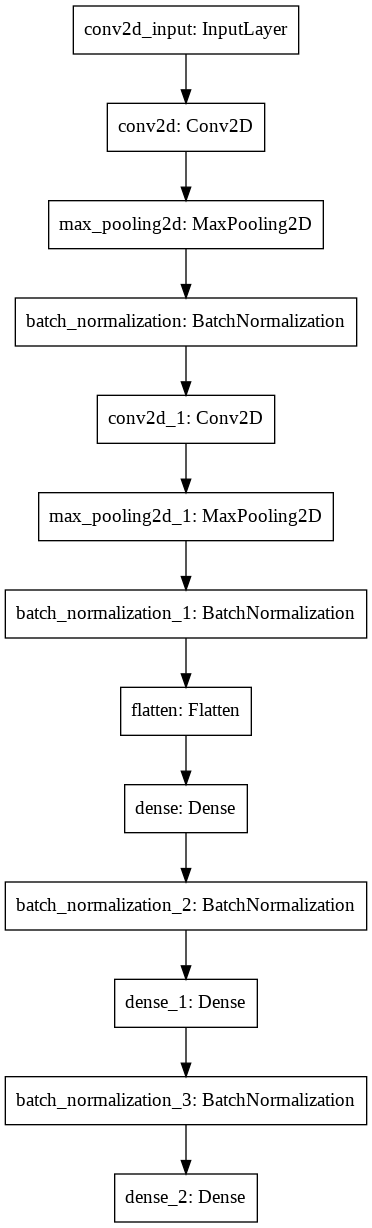

In [0]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/architecture_cnn_model_clf.png")

## Model evalution and analysis

### Testing data preparation for analysis

In [0]:
y_test = ['Speech' if np.argmax(item)==0 else 'Non-Speech' for item in y_test]
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype('int16')
y_pred = ['Speech' if np.argmax(item)==0 else 'Non-Speech' for item in y_pred]

### Accuracy Score

In [0]:
print(f'Accuracy of Model : {accuracy_score(y_test, y_pred)}')

Accuracy of Model : 0.9941775836972343


### Confusion matrix plot and saving the plot

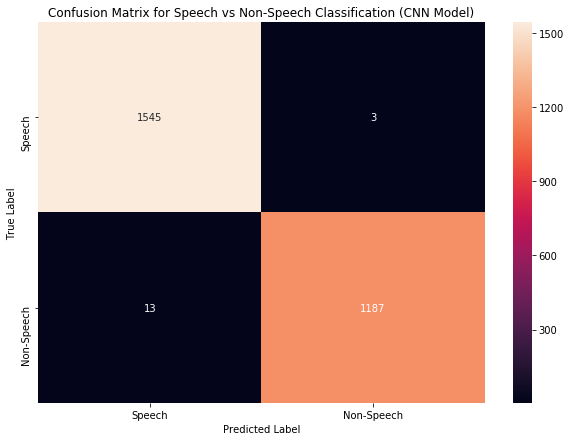

In [0]:
conf_matrix = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(conf_matrix, index = ['Speech', 'Non-Speech'],
                  columns = ['Speech', 'Non-Speech'])
plt.figure(figsize = (10,7))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax = sn.heatmap(df_cm, annot=True, fmt="d")
ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Matrix for Speech vs Non-Speech Classification (CNN Model)')
figure = ax.get_figure()    
figure.savefig("drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/confusion_matrix_cnn_model_clf.png")

### Classification report of model and saving the table as csv

In [0]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = np.round(report_df,2)
report_df

,f1-score,precision,recall,support
Non-Speech,0.99,0.99,1.00,1548.00
Speech,0.99,1.00,0.99,1200.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,2748.00
weighted avg,0.99,0.99,0.99,2748.00


In [0]:
report_df.to_csv("drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/classification_report_cnn_model_clf.csv")

### Model training vs validation loss plot

In [0]:
history = pickle.load(open('drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/history_cnn_model_clf_with_param_14,418_val_loss_0.0141_val_acc_0.9955_tf.keras.pkl', 'rb'))

In [0]:
train_loss = history['loss']
train_acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']

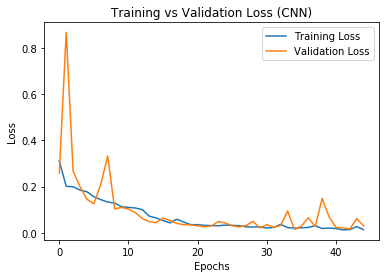

In [0]:
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (CNN)')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.savefig("drive/My Drive/Project/Models/Speech vs Non-Speech Classification/CNN Model/loss_graph_cnn_model_clf.png")
plt.show()